# Import Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from torch_geometric.data import Data, InMemoryDataset, download_url, Batch
import torch_geometric.transforms as T
from dgl.data.utils import Subset, load_graphs
from torch_geometric.utils import k_hop_subgraph
import torch
import torch_geometric
import pdb
#from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, ELU, GELU
from torch_geometric.nn import GINConv, GINEConv, WLConv, GATv2Conv
import torch.optim as optim
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
warnings.filterwarnings('ignore')
from tqdm import tqdm
import torch.utils.data
from torch.utils.data.dataloader import default_collate

from torch_geometric.data import Data
import collections.abc as container_abcs
from scipy.special import comb

# Dataset Creation

In [85]:
#Dataset class
class Dataset_1_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_1_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset1_orig.pt']

    def download(self):
        pass
    
    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)
                    
            l = torch.cat((l, torch.tensor([ll])), dim=0)
       
        
        return torch.ceil(torch.sum(l)/4)
    
    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

       
        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = chord.item()
        return data

    def process(self):
        glist, all_labels = load_graphs("/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset1.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

class Dataset_2_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_2_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset2_orig.pt']

    def download(self):
        pass

    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)
                    
            l = torch.cat((l, torch.tensor([ll])), dim=0)
       
        
        return torch.ceil(torch.sum(l)/4)

    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

        
        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = chord.item()

        return data

    def process(self):
        glist, all_labels = load_graphs("/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset2.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# Helper

In [86]:
class collater():
    def __init__(self, task):
        self.task = task
        pass

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            if self.task == "triangle":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                num_edges += edge_index_.shape[1]
                
            elif self.task == "3star":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T

                mask = (edge_index_ == ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                l = torch.cat((l, torch.tensor([nodes_.shape[0]-1])), dim=0)
                k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,3, exact=True)])), dim=0)
            
            elif self.task == "C4":
                node_dict = {}
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                nodes_ = nodes_[nodes_ != ind]
                edge_list = edge_index_.tolist()
                node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in nodes_}
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                x = torch.ones([num_nodes, 1]).to(edge_index.device)
                for n in node_dict:
                    if node_dict[n] == 2:
                        x[n] = torch.tensor([2])
                    else:
                        x[n] = torch.tensor([1])
                
                data_ = Data(edge_index=edge_index_, z=z_)
                ll = 0
                edge_list = edge_index_.T.tolist()
                total_nei = 0
                for n in node_dict:
                    nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                    if nei >= 2:
                        total_nei = total_nei + nei
                        ll += comb(nei, 2, exact=True)
                        
                l = torch.cat((l, torch.tensor([ll])), dim=0)
                k = torch.cat((k, torch.tensor([ll])), dim=0)

            subgraphs[ind] = data_
            
        total_edge_index = torch.unique(total_edge_index, dim=0)

        if self.task == "triangle":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.triangle
            new_data.ext_label = torch.tensor([num_edges//6]) 
        elif self.task == "3star":
            new_data = Data(edge_index=data.edge_index)
            new_data.ext_label_dataset = data.star
            new_data.ext_label = torch.sum(k)
        elif self.task == "C4":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.C4
            new_data.ext_label = torch.ceil(torch.sum(k)/4)
        return new_data, subgraphs, l

    def __call__(self, data):
        graphs = []
        subgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels

        return [graphs, subgraphs, labels, max_nodes]

# Model

In [87]:
class localGNN(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(localGNN, self).__init__()
        self.hidden = hidden
        self.conv1 = GINConv(Sequential(Linear(1, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv2 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc0 = Linear(hidden, hidden)
        self.fc1 = Linear(hidden, 1)

    def forward(self, data_list, subgraph_dict_list, max_nodes):
        out_dims = (len(data_list), max_nodes, self.hidden)
        int_emb = torch.zeros(out_dims).to(data_list[0].edge_index.device)
        num = 0
        new_data_list = []
        for graph, sub_graphs in zip(data_list, subgraph_dict_list):
            emb = torch.tensor([]).to(data_list[0].edge_index.device)
            for key in sub_graphs.keys():
                subgraph = sub_graphs[key]
                edge_index = subgraph.edge_index
                subgraph.x = torch.ones(
                    [subgraph.num_nodes, 1]).to(edge_index.device)
                x = self.conv1(subgraph.x, edge_index)
                x = self.conv2(x, edge_index)
                x = self.fc0(x)
                x = F.gelu(x)
                if len(x)>0:
                    batch = torch.zeros(len(x), dtype=torch.long).to(data_list[0].edge_index.device)
                    x = global_add_pool(x, batch, size=1)
                else:
                    x = torch.zeros(1, self.hidden).to(data_list[0].edge_index.device)
                emb = torch.cat((emb, x), dim=0)
            int_emb[num, :emb.shape[0], :] = emb
            num += 1
            graph.x = emb  
            new_data_list.append(graph) 
        res = self.fc1(int_emb)
        batch = Batch.from_data_list(new_data_list)
        res = torch.squeeze(res, dim=-1)
        return batch, res


In [89]:
class globalGNN(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(globalGNN, self).__init__()
        self.hidden = hidden
        self.conv3 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv4 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc2 = Linear(hidden, 1)

    def forward(self, data):
        
        
        x = self.conv3(data.x, data.edge_index)
        x = self.conv4(x, data.edge_index)
        #x = F.elu(x)
        x = self.fc2(x)
        x = global_add_pool(x, data.batch)
        return x


In [10]:
import torch
A = torch.tensor([[1,2],[3,4],[5,6]])

In [11]:
torch.tensor([5,7]) in A

True

# Data Processing and Split

In [95]:
dataset2_orig = Dataset_2_orig(root="/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/Dataset2", pre_transform=None)
train_dataset_G = dataset2_orig[:int(0.8*len(dataset2_orig))]
val_dataset_G = dataset2_orig[int(0.8*len(dataset2_orig)):int(0.9*len(dataset2_orig))]
test_dataset_G = dataset2_orig[int(0.9*len(dataset2_orig)):]
task = "C4"
if task == "triangle":
    variance2_orig = torch.std(dataset2_orig.data.triangle.to(torch.float32))**2
elif task == "3star":
    variance2_orig = torch.std(dataset2_orig.data.star.to(torch.float32))**2
elif task == "C4":
    variance2_orig = torch.std(dataset2_orig.data.C4.to(torch.float32))**2

from torch.utils.data import DataLoader

collater_fn = collater(task)
train_loader = DataLoader(train_dataset_G, batch_size=1, shuffle=True, drop_last=True, collate_fn=collater_fn)
val_loader = DataLoader(val_dataset_G, batch_size=1, shuffle=False, drop_last=True, collate_fn=collater_fn)
test_loader = DataLoader(test_dataset_G, batch_size=1, shuffle=False, drop_last=True, collate_fn=collater_fn)

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for batch in train_loader:
    graphs = batch[0]
    subgraphs = batch[1]
    internal_labels = batch[2].to(device)
    max_nodes = batch[3]

    if graphs[0].ext_label != graphs[0].ext_label_dataset:
        print("found")

# Create Models

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Int_GNN = localGNN(1, 512).to(device)
Ext_GNN = globalGNN(1, 512).to(device)
Int_Opt = torch.optim.Adam(Int_GNN.parameters(), lr=0.001)
Ext_Opt = torch.optim.Adam(Ext_GNN.parameters(), lr=0.001)
loss_fn1 = torch.nn.L1Loss(reduction='mean')
loss_fn2 = torch.nn.L1Loss(reduction='mean')

In [100]:
#number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters in Int_GNN: ", count_parameters(Int_GNN))
print("Number of parameters in Ext_GNN: ", count_parameters(Ext_GNN))

Number of parameters in Int_GNN:  1052161
Number of parameters in Ext_GNN:  1051137


In [101]:
#memory taken by the model in MB
def memory(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)*4/1000000

print("Memory taken by Int_GNN: ", memory(Int_GNN), "MB")
print("Memory taken by Ext_GNN: ", memory(Ext_GNN), "MB")

Memory taken by Int_GNN:  4.208644 MB
Memory taken by Ext_GNN:  4.204548 MB


In [102]:
def train(int_model, ext_model, loader, int_opt, ext_opt):
    step = 0
    total_loss_int = 0
    total_loss_ext = 0
    for batch in tqdm(loader):
        graphs = batch[0]
        subgraphs = batch[1]
        internal_labels = batch[2].to(device)
        max_nodes = batch[3]
        
        for g in range(len(graphs)):
            graphs[g] = graphs[g].to(device)
            for key in subgraphs[g].keys():
                subgraphs[g][key] = subgraphs[g][key].to(device)

        int_model.train()
        int_opt.zero_grad()
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        loss1 = loss_fn1(int_out, internal_labels)
        loss1.backward()
        int_opt.step()
        #ext_model = param_transfer(int_model, ext_model)
        int_model.eval()
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        ext_model.train()
        ext_opt.zero_grad()
        ext_emb = ext_model(batch_graph)
        loss2 = loss_fn2(ext_emb, batch_graph.ext_label)
        loss2.backward()
        ext_opt.step()
        total_loss_int += loss1.item()
        total_loss_ext += loss2.item()
        step += 1
        if step % 500 == 0:
            print("Step: {}, Int Loss: {}, Ext Loss: {}".format(
                step, total_loss_int/step, total_loss_ext/step))
        #int_model = param_transfer(ext_model, int_model)
    return total_loss_ext / step

def eval(int_model, ext_model, loader):
    int_model.eval()
    ext_model.eval()
    step = 0
    total_loss = 0
    for batch in tqdm(loader):
        graphs = batch[0]
        subgraphs = batch[1]
        internal_labels = batch[2].to(device)
        max_nodes = batch[3]
        
        for g in range(len(graphs)):
            graphs[g] = graphs[g].to(device)
            for key in subgraphs[g].keys():
                subgraphs[g][key] = subgraphs[g][key].to(device)
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        ext_emb = ext_model(batch_graph)
        loss = loss_fn2(ext_emb, batch_graph.ext_label)
        total_loss += loss.item()
        step += 1
    return total_loss / step

# Run Model

In [103]:
train_curve = []
valid_curve = []
test_curve = []
best_val_loss = 1000
best_test_loss = 1000
for epoch in range(1, 101):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_loss = train(Int_GNN, Ext_GNN, train_loader, Int_Opt, Ext_Opt)
    print('Train loss : {}'.format(train_loss/variance2_orig))

    print('Evaluating...')
    valid_loss = eval(Int_GNN, Ext_GNN, val_loader)
    print('Valid loss : {}'.format(valid_loss/variance2_orig))
    test_loss = eval(Int_GNN, Ext_GNN, test_loader)
    print('Test loss : {}'.format(test_loss/variance2_orig))
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_test_loss = test_loss
        print("Best Model!")
        print("Best valid loss : {}".format(best_val_loss/variance2_orig))
        print("Best test loss : {}".format(best_test_loss/variance2_orig))
    train_curve.append(train_loss/variance2_orig)
    valid_curve.append(valid_loss/variance2_orig)
    test_curve.append(test_loss/variance2_orig)

=====Epoch 1
Training...


 13%|█▎        | 502/4000 [00:38<04:37, 12.59it/s]

Step: 500, Int Loss: 5.034586036205292, Ext Loss: 42.27191285705566


 25%|██▌       | 1002/4000 [01:17<04:37, 10.79it/s]

Step: 1000, Int Loss: 4.915372324705124, Ext Loss: 38.03900317001343


 38%|███▊      | 1502/4000 [01:57<03:10, 13.12it/s]

Step: 1500, Int Loss: 4.788568095207214, Ext Loss: 33.24460156504313


 50%|█████     | 2002/4000 [02:36<02:38, 12.62it/s]

Step: 2000, Int Loss: 4.744693721473217, Ext Loss: 31.69023730278015


 63%|██████▎   | 2502/4000 [03:15<01:47, 13.89it/s]

Step: 2500, Int Loss: 4.689019625139236, Ext Loss: 29.98272534637451


 75%|███████▌  | 3002/4000 [03:54<01:12, 13.84it/s]

Step: 3000, Int Loss: 4.66690969200929, Ext Loss: 28.490532993316652


 88%|████████▊ | 3502/4000 [04:32<00:39, 12.45it/s]

Step: 3500, Int Loss: 4.646706180674689, Ext Loss: 27.31186481693813


100%|██████████| 4000/4000 [05:10<00:00, 12.86it/s]


Step: 4000, Int Loss: 4.62114170652628, Ext Loss: 27.310226669311522
Train loss : 0.08640027791261673
Evaluating...


100%|██████████| 500/500 [00:12<00:00, 41.56it/s]


Valid loss : 0.08499457687139511


100%|██████████| 500/500 [00:10<00:00, 48.05it/s]


Test loss : 0.08802930265665054
Best Model!
Best valid loss : 0.08499457687139511
Best test loss : 0.08802930265665054
=====Epoch 2
Training...


 13%|█▎        | 502/4000 [00:39<04:08, 14.05it/s]

Step: 500, Int Loss: 4.463464473247528, Ext Loss: 23.973553581237795


 25%|██▌       | 1001/4000 [01:17<03:59, 12.53it/s]

Step: 1000, Int Loss: 4.455619666457176, Ext Loss: 22.262183292388915


 38%|███▊      | 1501/4000 [01:59<03:06, 13.38it/s]

Step: 1500, Int Loss: 4.413344955682755, Ext Loss: 20.87024910736084


 50%|█████     | 2001/4000 [02:37<02:22, 13.99it/s]

Step: 2000, Int Loss: 4.418791454553604, Ext Loss: 23.36675898551941


 63%|██████▎   | 2501/4000 [03:15<01:50, 13.58it/s]

Step: 2500, Int Loss: 4.411081143712997, Ext Loss: 22.765834593200683


 75%|███████▌  | 3001/4000 [03:53<01:14, 13.50it/s]

Step: 3000, Int Loss: 4.405248848040898, Ext Loss: 22.211167481740315


 88%|████████▊ | 3501/4000 [04:34<00:41, 11.93it/s]

Step: 3500, Int Loss: 4.391445282697678, Ext Loss: 21.71715282876151


100%|██████████| 4000/4000 [05:13<00:00, 12.76it/s]


Step: 4000, Int Loss: 4.382611571520567, Ext Loss: 21.1949343252182
Train loss : 0.06705357134342194
Evaluating...


100%|██████████| 500/500 [00:11<00:00, 44.85it/s]


Valid loss : 0.04554934799671173


100%|██████████| 500/500 [00:11<00:00, 41.86it/s]


Test loss : 0.04661869630217552
Best Model!
Best valid loss : 0.04554934799671173
Best test loss : 0.04661869630217552
=====Epoch 3
Training...


 13%|█▎        | 502/4000 [00:39<04:35, 12.68it/s]

Step: 500, Int Loss: 4.328822411298752, Ext Loss: 15.906507431030274


 25%|██▌       | 1002/4000 [01:17<03:57, 12.64it/s]

Step: 1000, Int Loss: 4.303832306265831, Ext Loss: 15.980106842041016


 38%|███▊      | 1502/4000 [01:56<03:36, 11.56it/s]

Step: 1500, Int Loss: 4.2945166252454126, Ext Loss: 15.976174112955729


 50%|█████     | 2002/4000 [02:34<02:28, 13.43it/s]

Step: 2000, Int Loss: 4.306012226879597, Ext Loss: 16.17426031112671


 63%|██████▎   | 2502/4000 [03:13<01:50, 13.50it/s]

Step: 2500, Int Loss: 4.303010956954956, Ext Loss: 16.472702288818358


 71%|███████   | 2822/4000 [03:38<01:37, 12.10it/s]

In [76]:
print("Best valid loss : {}".format(best_val_loss/variance2_orig))
print("Best test loss : {}".format(best_test_loss/variance2_orig))

Best valid loss : 0.0030952796805649996
Best test loss : 0.0033464173320680857


# Plots

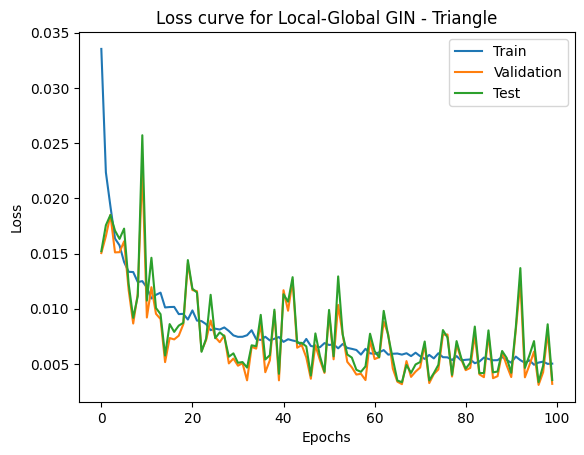

In [79]:
plt.plot(train_curve, label='Train')
plt.plot(valid_curve, label='Validation')   
plt.plot(test_curve, label='Test')
plt.legend()
plt.title('Loss curve for Local-Global GIN - Triangle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(train_curve, label='Train')
plt.plot(valid_curve, label='Validation')   
plt.plot(test_curve, label='Test')
plt.legend()
plt.title('Loss curve for Local-Global GIN - Star')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Others

In [82]:
def countC4(data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()
            print(edge_list)
            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])

                if nei >= 2:
                    print(n, nei, comb(nei, 2, exact=True))
                    ll += comb(nei, 2, exact=True)
            l = torch.cat((l, torch.tensor([ll])), dim=0)
       
        
        return torch.ceil(torch.sum(l)/4)

In [70]:

edge_index = torch.tensor([[1,0], [0,1], [2,0], [0,2], [3,0], [0,3], [4,0], [0,4], [1,2], [2,1], [2,3], [3,2], [3,4], [4,3], [4,2], [2, 4]])   

In [71]:
G = Data(edge_index=edge_index.T)

In [72]:
#convert to networkx graph
from torch_geometric.utils.convert import to_networkx
M = to_networkx(G)


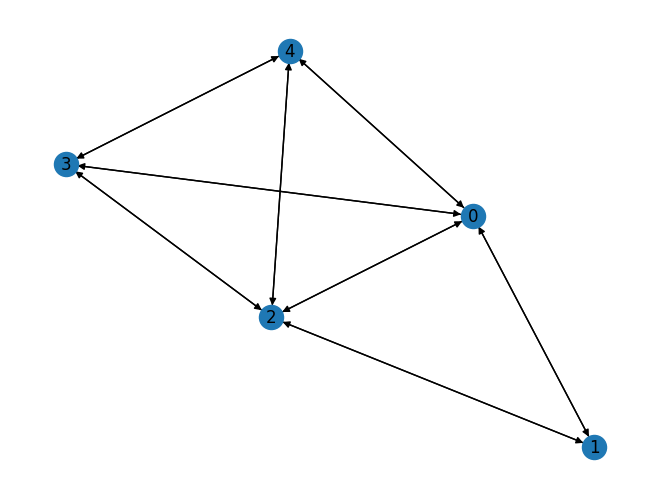

In [73]:
#plot the graph
import networkx as nx
nx.draw(M, with_labels=True)

In [83]:
M = countC4(G)

[[1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 2], [2, 4]]
2 3 3
3 2 1
4 2 1
[[2, 0], [0, 2], [3, 0], [0, 3], [4, 0], [0, 4], [2, 3], [3, 2], [3, 4], [4, 3], [4, 2], [2, 4]]
3 2 1
4 2 1
[[1, 0], [0, 1], [3, 0], [0, 3], [4, 0], [0, 4], [3, 4], [4, 3]]
0 3 3
3 2 1
4 2 1
[[1, 0], [0, 1], [2, 0], [0, 2], [4, 0], [0, 4], [1, 2], [2, 1], [4, 2], [2, 4]]
0 2 1
1 2 1
2 2 1
4 2 1
[[1, 0], [0, 1], [2, 0], [0, 2], [3, 0], [0, 3], [1, 2], [2, 1], [2, 3], [3, 2]]
0 2 1
1 2 1
2 2 1
3 2 1


In [75]:
M

tensor(5.)